# Evoked EPSCs and IPSCs

#### **Basic instructions:**
#### 1. **To run code cells**, you can either hit the play button to the left of the cell, or you can select the cell and **press shift-enter**.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files over from where they are saved on your computer.

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/Evoked_PSCs" folder

In [2]:
data_folder = "data/Evoked_PSCs"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/Evoked_PSCs


['data/Evoked_PSCs/2025_06_13_0008.abf',
 'data/Evoked_PSCs/2025_06_13_0020.abf',
 'data/Evoked_PSCs/2025_06_13_0009.abf',
 'data/Evoked_PSCs/2025_06_13_0019.abf',
 'data/Evoked_PSCs/2025_06_13_0018.abf',
 'data/Evoked_PSCs/2024_06_14_0002.abf',
 'data/Evoked_PSCs/2024_06_14_0007.abf',
 'data/Evoked_PSCs/2025_06_13_0016.abf',
 'data/Evoked_PSCs/2025_06_13_0002.abf',
 'data/Evoked_PSCs/2025_06_13_0003.abf',
 'data/Evoked_PSCs/2025_06_13_0017.abf',
 'data/Evoked_PSCs/2025_06_13_0001.abf',
 'data/Evoked_PSCs/2025_06_13_0015.abf',
 'data/Evoked_PSCs/2025_06_13_0014.abf',
 'data/Evoked_PSCs/2025_06_13_0000.abf',
 'data/Evoked_PSCs/2025_06_13_0004.abf',
 'data/Evoked_PSCs/2025_06_13_0010.abf',
 'data/Evoked_PSCs/2025_06_13_0011.abf',
 'data/Evoked_PSCs/2025_06_13_0005.abf',
 'data/Evoked_PSCs/2025_06_13_0013.abf',
 'data/Evoked_PSCs/2025_06_13_0007.abf',
 'data/Evoked_PSCs/2025_06_13_0006.abf',
 'data/Evoked_PSCs/2025_06_13_0012.abf']

Choose which file you want to analyze (copy name from above) and paste the file name here:

In [85]:
# data_file = 'data/Evoked_PSCs/2025_06_13_0008.abf'
data_file = 'data/Evoked_PSCs/2025_06_13_0012.abf'

Now we can load the file and plot the raw data:

In [86]:
# Or use the convenience flag
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=True,
                              units=['pA', 'mV', 'V'], 
                              concatenate_sweeps=False)
print(traces)

Trace('2025_06_13_0012.abf')
Number of sweeps: 20
Points per sweep: 15,000
Duration per sweep: 1.500 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage, TTL


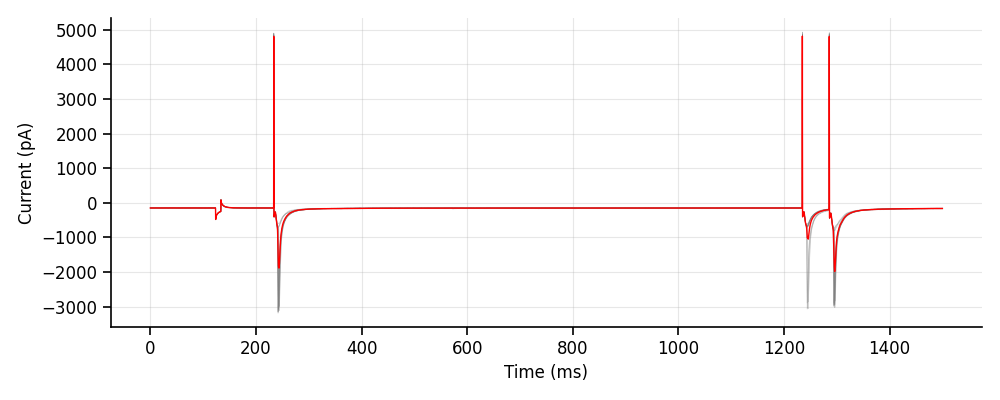

In [87]:
# traces.plot(plot_ttl=False, plot_voltage=False, sweep=3, time_units='ms')
traces.plot(plot_ttl=False, plot_voltage=False, sweep='all', time_units='ms')
# ax1, ax2 = traces.plot(plot_voltage=True, sweep='all')
plt.show()

## 2. Signal processing

### Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [88]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True

BASELINE SUBTRACTED:
Baseline currents: [-142.688  -143.9545 -141.745  ... -150.4425 -153.36   -151.3306]
Baseline voltages: [-1405.4138 -1405.6641 -1404.248  ... -1404.4373 -1404.5044 -1404.2175]


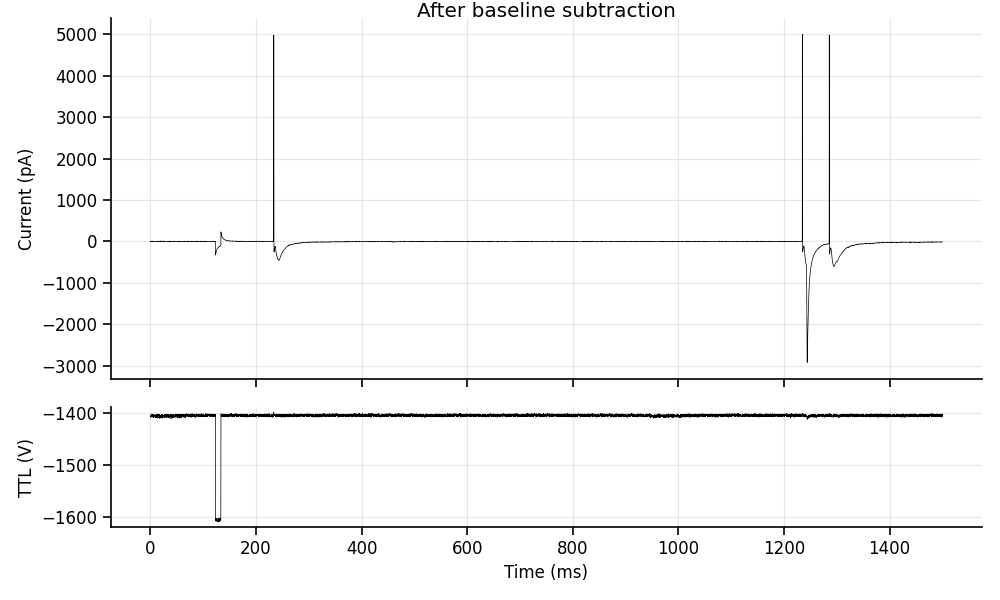

In [89]:
if subtract_baseline:
    traces.subtract_baseline(start_time = 0, 
                             end_time = 10, 
                             units = 'ms',  # specify seconds (s), or milliseconds (ms)
                             channel = 'all')  # Options: 'current', 'voltage', 'all'
    ax1, ax2 = traces.plot(plot_voltage=False, plot_ttl=True, time_units='ms')
    ax1.set_title('After baseline subtraction', y=0.98)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


### Optional: apply additional highpass/lowpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [120]:
# Change this to True if you want to subtract the baseline from the sweeps.
additional_filtering = False

In [121]:
if additional_filtering:
    filtered_traces = traces
    # Step 1: Detrend the data to remove linear or constant trends.
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

    # Step 2: Apply a highpass filter to remove low-frequency noise + lowpass to remove high-frequency noise
    filtered_traces = filtered_traces.filter(
        line_freq=60,    # Frequency (Hz) of electrical noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width=1,         # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        highpass=0.01,   # Removes low-frequency drift. Set a value in Hz (e.g. 1 for 1 Hz).
        lowpass=2000,    # Removes high-frequency noise. Set a value in Hz (e.g. 100 for 100 Hz).
        order=4)         # Controls sharpness of the filter. Higher = sharper cutoff.


    ax = filtered_traces.plot(plot_voltage=False, plot_ttl=False)
    ax.set_title('After filtering', y=0.98)
    plt.show()

Once yopu are happy with the filter setting, run the next cell to implement them:

In [122]:
if additional_filtering:
    traces=filtered_traces

## 3. Measure EPSCs/IPSCs to get paired pulse ratio

(If you want to save images, click on the save icon on the left when you hover over the image)

### 3.1. Get the single-stim response


In [210]:
# Find positive current peaks above threshold
stim_times = traces.get_event_times(threshold=4000, polarity='positive', 
                                    time_units='ms', channel='current', sweep_idx=0)
print(f"Stim times: {stim_times} ms")

Stim times: [ 233.7 1234.7 1285.7] ms


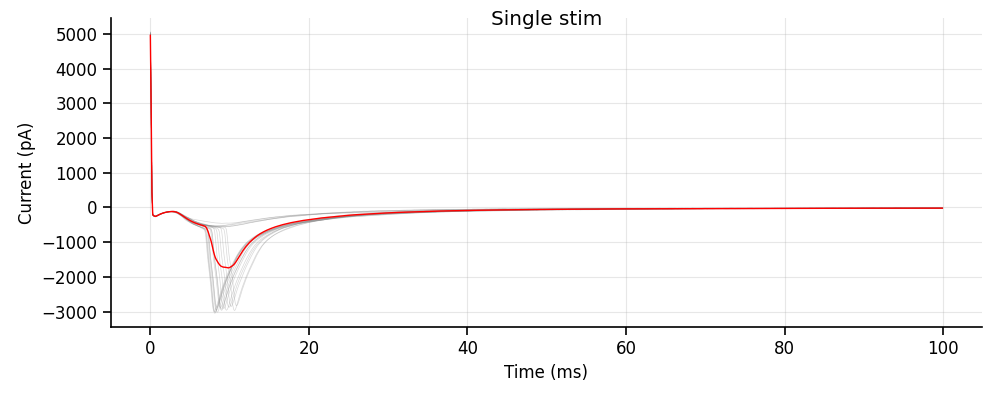

In [211]:
window_size = 100 #ms
single_stim_traces = traces.crop(timepoint=stim_times[0], window=window_size, units='ms')
ax = single_stim_traces.plot(plot_voltage=False, plot_ttl=False, time_units='ms', sweep='all')
ax.set_title('Single stim',y=0.95)
plt.show()

#### Optional: remove bad traces

Removed 15 sweeps with spikes (kept 5 sweeps)


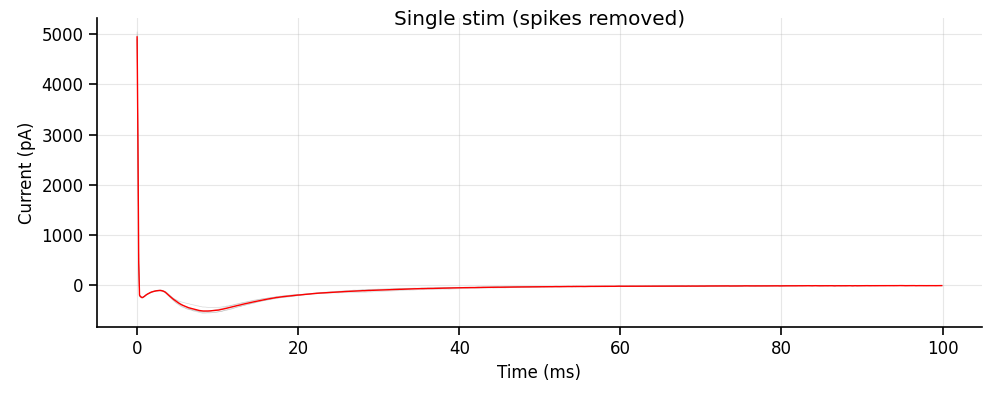

In [212]:
remove_spikes = True

# ---------------------------------------------------------------------------------------------------------
if remove_spikes:
    # Remove sweeps with positive current spikes above or below threshold
    info = single_stim_traces.remove_sweeps_with_spikes(threshold=-2000, polarity='negative', 
                                                channel='current', return_info=True)

    ax = single_stim_traces.plot(plot_voltage=False, plot_ttl=False, time_units='ms', sweep='all')
    # ax.set_ylim(bottom=-600, top=100)
    ax.set_title('Single stim (spikes removed)',y=0.95)
    plt.show()

#### Measure single-stim amplitudes

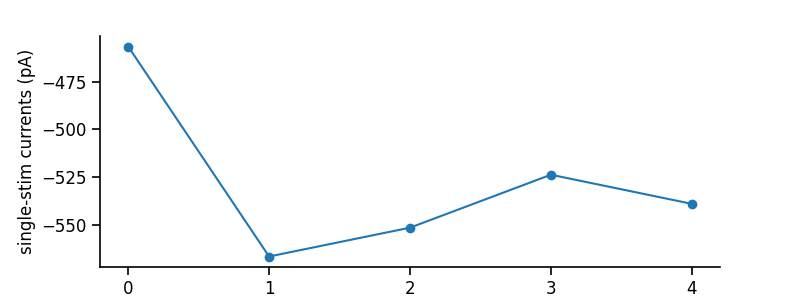

In [213]:
single_stim_currents, _ = single_stim_traces.get_step_measurements(start_time=4, 
                                                                end_time=15, 
                                                                measurement_type='min', 
                                                                units='ms')
fig,ax = plt.subplots(figsize=(8,3))
ax.plot(single_stim_currents, '-o')
ax.set_xticks(range(len(single_stim_currents)))
ax.set_ylabel('single-stim currents (pA)')
ax.set_xlabel("sweep nr.")
plt.show()

### 3.2. Get the response to the first paired-pulse stim

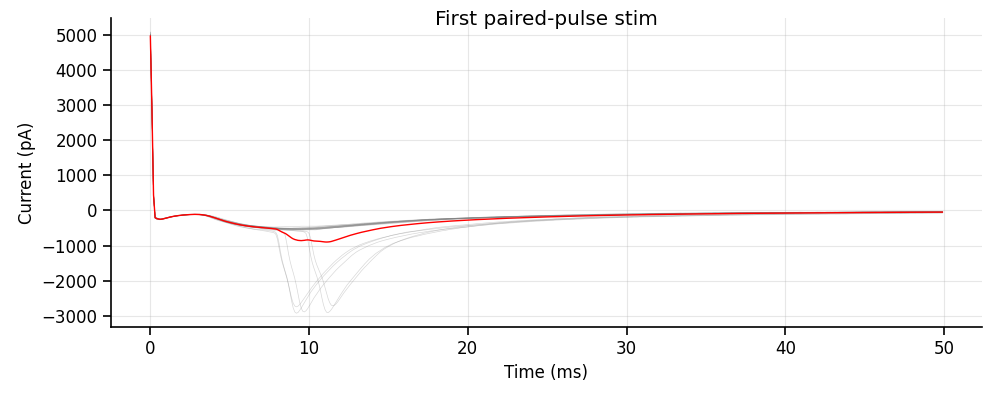

In [214]:
first_pulse_traces = traces.crop(timepoint=stim_times[1], window=window_size/2, units='ms')
ax = first_pulse_traces.plot(plot_voltage=False, plot_ttl=False, time_units='ms', sweep='all')
ax.set_title('First paired-pulse stim',y=0.95)
plt.show()

#### Optional: remove bad traces

Removed 5 sweeps with spikes (kept 15 sweeps)


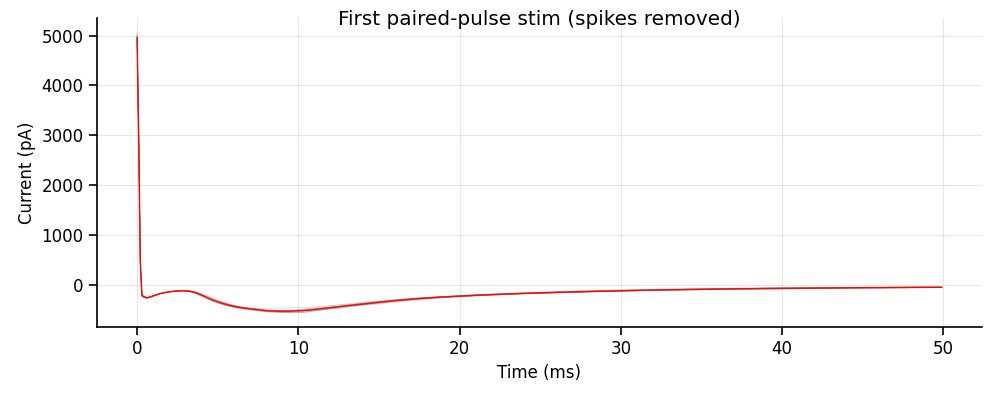

In [215]:
remove_spikes = True

# ---------------------------------------------------------------------------------------------------------
if remove_spikes:
    # Remove sweeps with positive current spikes above or below threshold
    info = first_pulse_traces.remove_sweeps_with_spikes(threshold=-2000, polarity='negative', 
                                                channel='current', return_info=True)
    ax = first_pulse_traces.plot(plot_voltage=False, plot_ttl=False, time_units='ms', sweep='all')
    # ax.set_ylim(bottom=-600, top=100)
    ax.set_title('First paired-pulse stim (spikes removed)',y=0.95)
    plt.show()

#### Measure first paired-pulse amplitudes

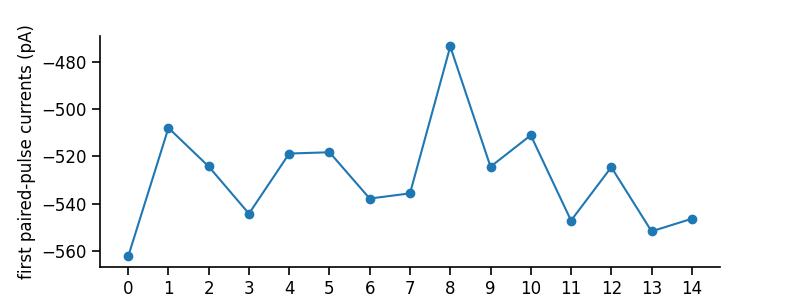

In [216]:
first_pulse_currents,_ = first_pulse_traces.get_step_measurements(start_time=4, 
                                                                end_time=15, 
                                                                measurement_type='min', 
                                                                units='ms')
fig,ax = plt.subplots(figsize=(8,3))
ax.plot(first_pulse_currents, '-o')
ax.set_xticks(range(len(first_pulse_currents)))
ax.set_ylabel('first paired-pulse currents (pA)')
ax.set_xlabel("sweep nr.")
plt.show()

### 3.3. Get the response to the second paired-pulse stim

#### Subtract single-stim response from paired-pulse trace

This allows us to recover the shape/amplitude of the second pulse, without the contribution of the first pulse

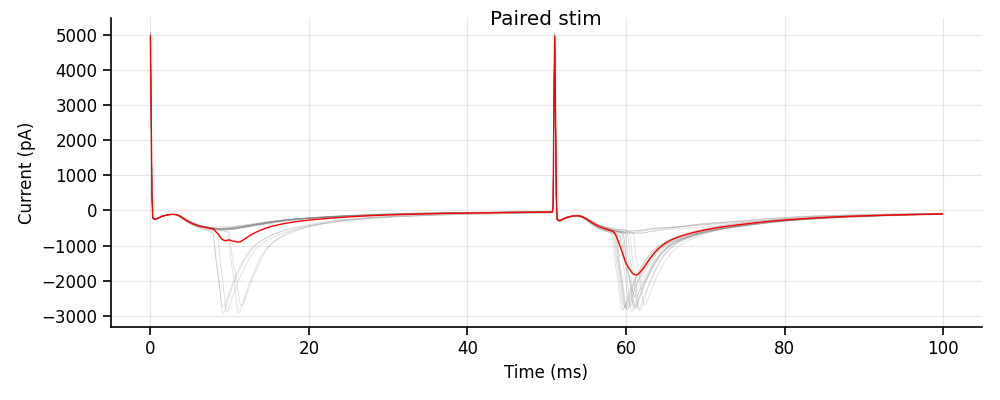

In [217]:
paired_pulse_traces = traces.crop(timepoint=stim_times[1], window=window_size, units='ms')
ax = paired_pulse_traces.plot(plot_voltage=False, plot_ttl=False, time_units='ms', sweep='all')
ax.set_title('Paired stim',y=0.95)
plt.show()

Now we will get the average "first stim" response and subtract it from all of the paired-pulse sweeps

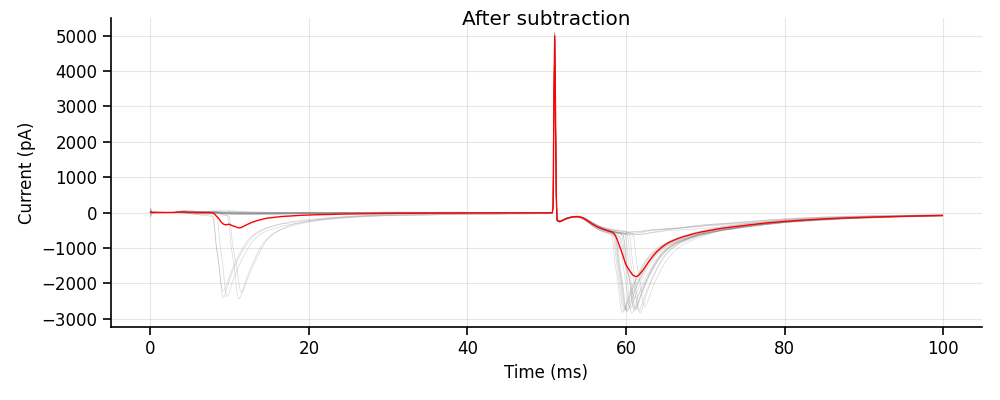

In [218]:
subtracted_traces = paired_pulse_traces.copy()
subtract_average_single_stim = True   # We can either subtract the average single-stim, or subtract each individual single-stim (from every sweep)

if subtract_average_single_stim:
    avg_single_stim_trace = np.mean(single_stim_traces.current_data, axis=0)
    subtracted_traces.current_data -= avg_single_stim_trace
else:
    subtracted_traces.current_data -= single_stim_traces.current_data

ax = subtracted_traces.plot(plot_voltage=False, plot_ttl=False, time_units='ms', sweep='all')
ax.set_title('After subtraction',y=0.95)
plt.show()

Now we need to isolate the second pulse


In [219]:
# Find positive current peaks above threshold
stim_time = subtracted_traces.get_event_times(threshold=4000, polarity='positive', 
                                    time_units='ms', channel='current', sweep_idx=0)
print(f"Stim times: {stim_time} ms")

Stim times: [51.] ms


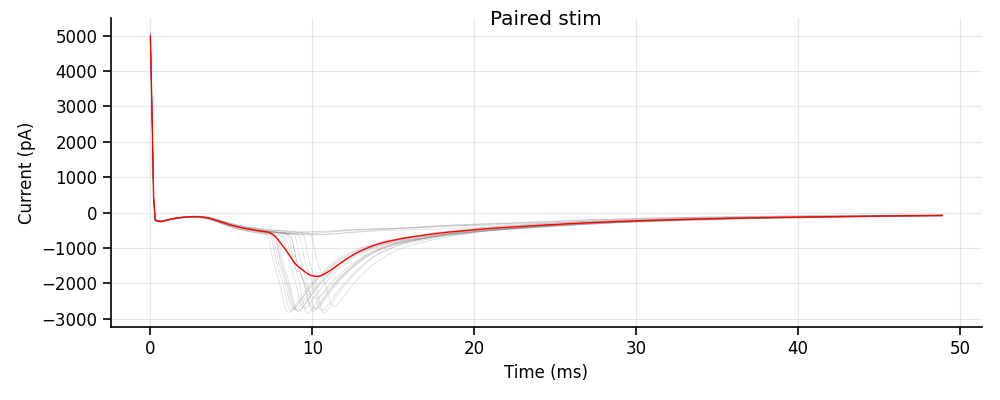

In [220]:
second_pulse_traces = subtracted_traces.crop(timepoint=stim_time[0], timepoint_2=subtracted_traces.total_time_ms, units='ms')
ax = second_pulse_traces.plot(plot_voltage=False, plot_ttl=False, time_units='ms', sweep='all')
ax.set_title('Paired stim',y=0.95)
plt.show()

#### Optional: remove bad traces

Removed 15 sweeps with spikes (kept 5 sweeps)


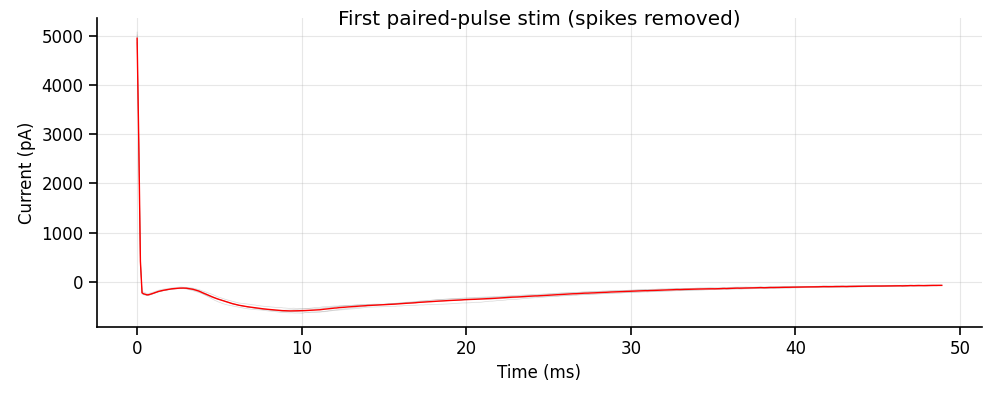

In [221]:
remove_spikes = True

# ---------------------------------------------------------------------------------------------------------
if remove_spikes:
    # Remove sweeps with positive current spikes above or below threshold
    info = second_pulse_traces.remove_sweeps_with_spikes(threshold=-2000, polarity='negative', 
                                                channel='current', return_info=True)
    ax = second_pulse_traces.plot(plot_voltage=False, plot_ttl=False, time_units='ms', sweep='all')
    # ax.set_ylim(bottom=-600, top=100)
    ax.set_title('First paired-pulse stim (spikes removed)',y=0.95)
    plt.show()

#### Measure second paired-pulse amplitudes

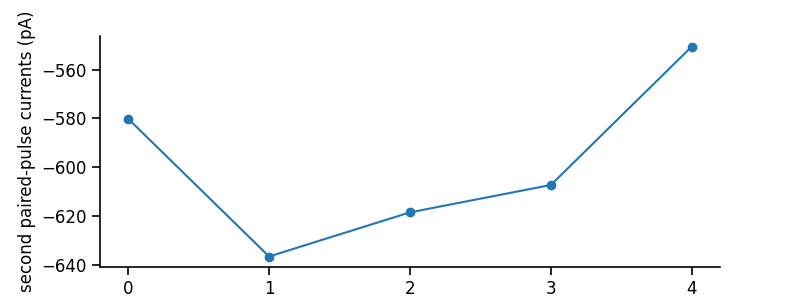

In [223]:
second_pulse_currents,_ = second_pulse_traces.get_step_measurements(start_time=4, 
                                                                end_time=15, 
                                                                measurement_type='min', 
                                                                units='ms')
fig,ax = plt.subplots(figsize=(8,3))
ax.plot(second_pulse_currents, '-o')
ax.set_xticks(range(len(second_pulse_currents)))
ax.set_ylabel('second paired-pulse currents (pA)')
ax.set_xlabel("sweep nr.")
plt.show()

### 3.4. Plot paired-pulse ratio

In [225]:
if len(first_pulse_currents) == len(second_pulse_currents):
    paired_pulse_ratios = second_pulse_currents / first_pulse_currents
    avg_ppr = np.mean(paired_pulse_ratios)
    fig,ax = plt.subplots()
    ax.plot(paired_pulse_ratios, '-o')
    ax.set_xticks(range(len(second_pulse_currents)))
    ax.set_ylabel('Paired-pulse ratios')
    xlims = ax.get_xlim()
    ax.hlines(1,xlims[0],xlims[1],'--',color='gray')
    ax.text(f"Paired-pulse ratio: {avg_ppr}", ylims[1], label, fontsize=10, color='red', ha='center', va='bottom')
    ax.set_xlabel("sweep nr.")
    plt.show()
else:
    avg_second_pulse = np.mean(second_pulse_currents)
    avg_first_pulse = np.mean(first_pulse_currents)
    paired_pulse_ratio = avg_second_pulse / avg_first_pulse
    print(f"Paired-pulse ratio: {paired_pulse_ratio}")


Paired-pulse ratio: 1.132628066519023
